In [1]:
from nanopelican.models import load_experiment
import matplotlib.pyplot as plt

In [2]:
model, history = load_experiment('experiments/nano-8')




{'class_name': '__tensor__', 'config': {'value': 2365, 'dtype': 'int64'}}


In [3]:
print(model.__dict__)

{'_self_setattr_tracking': True, '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping True>: 3, <_ObjectIdentityWrapper wrapping <keras.src.saving.serialization_lib.Config object at 0x00000156183F2490>>: 1, <_ObjectIdentityWrapper wrapping 1>: 2, <_ObjectIdentityWrapper wrapping 'relu'>: 1, <_ObjectIdentityWrapper wrapping 'fourvec'>: 1, <_ObjectIdentityWrapper wrapping 0.0>: 1, <_ObjectIdentityWrapper wrapping 49>: 1, <_ObjectIdentityWrapper wrapping <nanopelican.layers.inputs.DataHandler object at 0x0000015641BBB250>>: 1, <_ObjectIdentityWrapper wrapping <nanopelican.layers.lineq.Lineq2v2nano object at 0x0000015641BF3D50>>: 1, <_ObjectIdentityWrapper wrapping <nanopelican.layers.lineq.Lineq2v0nano object at 0x0000015642F41C50>>: 1, <_ObjectIdentityWrapper wrapping <keras.src.saving.serialization_lib.Config object at 0x0000015642DCFDD0>>: 1, <_ObjectIdentityWrapper wrapping <keras.src.optimizers.adamw.AdamW object at 0x0000015641BF3C90>>: 1, <_Objec

In [4]:
for key in history:
    print(key)

loss = history['loss']
acc = history['acc']
val_loss = history['val_loss']
val_acc = history['val_acc']
args = history['args']

loss
acc
val_loss
val_acc
args


In [5]:
for key, val in args.__dict__.items():
    print(key, val)

evaluate_models None
n_hidden 1
n_outputs 1
activation relu
dropout_rate 0.0
use_batchnorm True
data_dir new_data/default
data_format fourvec
feature_key Pmu
label_key is_signal
num_particles 80
num_particles_avg 49
print_summary True
batch_size 512
epochs 20
validation_size 1000
experiment_root experiments
experiment_name nano


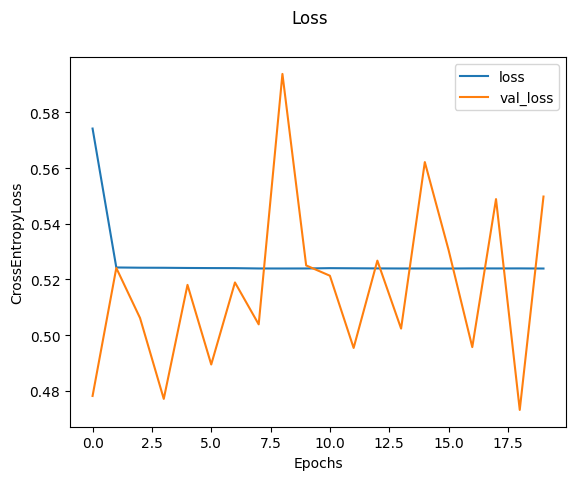

In [6]:
fig, ax = plt.subplots()
ax.plot(loss, label='loss')
ax.plot(val_loss, label='val_loss')
ax.set_ylabel("CrossEntropyLoss")
ax.set_xlabel("Epochs")
fig.suptitle("Loss")
plt.legend()

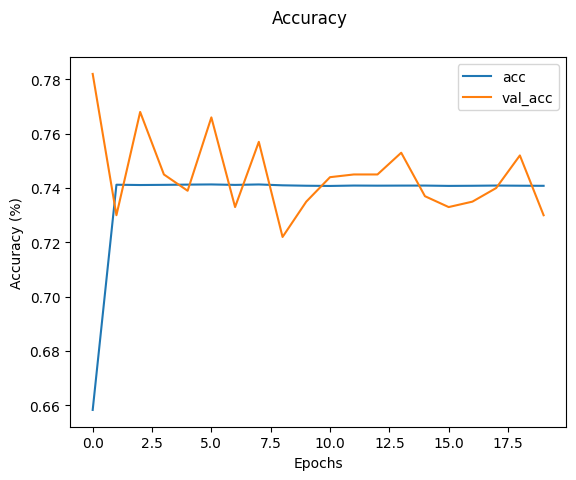

In [7]:
fig, ax = plt.subplots()
ax.plot(acc, label='acc')
ax.plot(val_acc, label='val_acc')
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Epochs")
fig.suptitle("Accuracy")
plt.legend()

In [8]:

optimizer = model.optimizer
conf = optimizer.get_config()['learning_rate']#['config']

In [9]:
import tensorflow as tf
scheduler = optimizer._learning_rate
steps = tf.range(scheduler.epochs*scheduler.steps_per_epoch, dtype=tf.float32, delta=scheduler.steps_per_epoch//10)
learning_rate = tf.map_fn(scheduler, steps)


Text(0.5, 0.98, 'LR schedule')

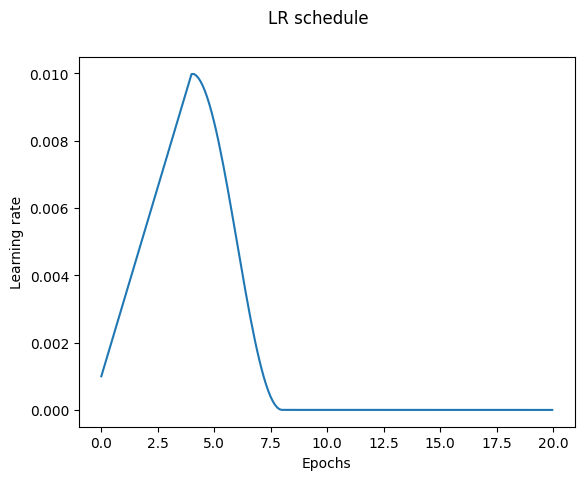

In [10]:
plt.plot(steps / scheduler.steps_per_epoch, learning_rate)
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.suptitle("LR schedule")

Text(0.5, 0.98, 'LR schedule')

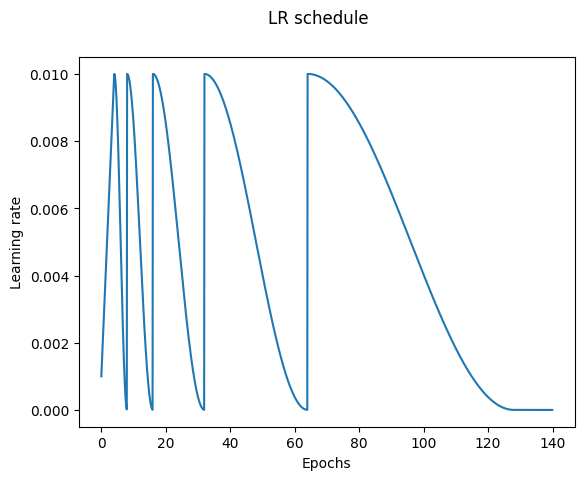

In [11]:
from nanopelican.schedulers import LinearWarmupCosineAnnealing
scheduler = LinearWarmupCosineAnnealing(140, 200)
steps = tf.range(scheduler.epochs*scheduler.steps_per_epoch, dtype=tf.float32, delta=scheduler.steps_per_epoch//10)
learning_rate = tf.map_fn(scheduler, steps)

plt.plot(steps / scheduler.steps_per_epoch, learning_rate)
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.suptitle("LR schedule")



In [12]:
import numpy as np
with open('learning_rate.txt', 'r') as file:
    data = []
    for line in file.readlines():
        line = line.rstrip()
        data.append([float(line)])


data = np.array(data)

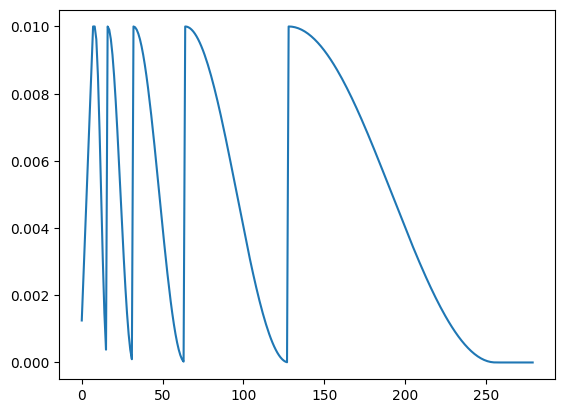

In [13]:
plt.plot(data)

In [14]:
w = model.get_weights()
w = np.concatenate([elem.flatten() for elem in w])
print(w)


[-5.1042295e-01  1.8081037e+00 -7.9109669e-02 -7.9100490e-02
  5.0211325e+00  3.9646883e+00  1.8134631e-01 -1.7106965e-01
  4.5063901e+00  1.9181664e+00  1.3232430e+02  9.6756109e+04
  1.9841398e+00  2.9517436e+00 -6.8252754e-01  3.6363761e+00
 -9.7148126e-01  2.1596417e-01  5.9803814e-01]


[-5.8622682e-01 -2.7858583e+01  1.9354626e+00  1.9354628e+00
 -3.0946710e+00  1.2841822e+01 -9.4749236e-01  2.4603009e+00
  1.4589891e+01 -7.5179869e-01  1.3198093e+02  9.6400555e+04
 -3.0164492e+01  1.9119540e+00 -2.3369765e+00  1.5639806e+01
 -4.5949030e+00  4.2646470e+00  5.3949780e+00]